# Analysis of patterened ground data

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skbio.stats.distance import permanova
from collections import Counter
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [9]:
map_df = pd.read_csv('../Bioinformatics/mapping_file/Final_mapping_file.csv', index_col = 0, skiprows=[1])
map_df.sort_index(inplace = True)
# map_df.at['PG-PG3-8', 'BG_umol/cm^2 SF C'] = 0
# already preformed the below code
map_df['C_kg_m_2'] = map_df['C (g/m^2)']/1000
map_df['N_kg_m_2'] = map_df['N (g/m^2)']/1000
# data['org C (kg/m^2)'] = data['C (kg/m^2)']*data['% Org C']
# data.to_csv('../Bioinformatics/mapping_file/Data_Compiled.csv', index = False)
map_df.head()

,LinkerPrimerSequence,BarcodeSequence,Landform,Pit,Landform.1,ID,Depth(cm),Depth_category,Depth_PG_M,x,...,CBH_umol/cm^2 SF C,PHOS_umol/cm^2 SF C,NAG_umol/cm^2 SF C,BX_umol/cm^2 SF C,AG_umol/cm^2 SF C,LAP_umol/cm^2 SF C,C (kg/m^2),org C (kg/m^2),C_kg_m_2,N_kg_m_2
#SampleID,,,,,,,,,,,,,,,,,,,,,
M-SS2-11,GTGCCAGCMGCCGCGGTAA,ACTACGTGTGGT,M,M1,M,5,11,A,MA,-106.3302,...,NaN,NaN,NaN,NaN,NaN,NaN,2.294039,12.754855,2.294039,0.206733
M-SS2-130,GTGCCAGCMGCCGCGGTAZA,CCTCTCGTGATC,M,M1,M,8,130,B,MB,-106.3302,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.084524,0.145382,0.084524,0.000000
M-SS2-160,GTGCCAGCMGCCGCGGTAA,CATATCGCAGTT,M,M1,M,9,160,B,MB,-106.3302,...,NaN,NaN,NaN,NaN,NaN,NaN,0.197268,0.274203,0.197268,0.016439
M-SS2-30,GTGCCAGCMGCCGCGGTAA,AGCTGACTAGTC,M,M1,M,6,30,A,MA,-106.3302,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.025437,1.261287,1.025437,0.083284
M-SS2-80,GTGCCAGCMGCCGCGGTAA,CCGACTGAGATG,M,M1,M,7,80,B,MB,-106.3302,...,189.976736,0.0,0.0,0.0,0.0,0.0,1.201094,1.405281,1.201094,0.090894


In [10]:
features = ['BG_umol/cm^2 SF C',
       'CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C', 'NAG_umol/cm^2 SF C',
       'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C']
map_df_na = map_df[features].dropna()
# Separating out the features
x = map_df_na.loc[:, features].values
# Separating out the target
# y = map_df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, index = map_df_na.index
             , columns = ['PCA 1', 'PCA 2'])
map_df = pd.concat([map_df, principalDf], axis = 1)

In [11]:
stats_df = pd.DataFrame()
columns_test = []
test = []
mean_right = []
mean_left = []
std_right = []
std_left = []
comparisons = {'M v PG':['M', 'PG'], 'MA v MB': ['MA','MB'], 'PGA v PGB':['PGA','PGB'], 
               'MA v PGA':['MA','PGA'], 'MB v PGB':['MB','PGB']}
means ={0:[],1: []}
lowers = {0:[],1: []}
uppers = {0:[],1: []}
columns = ['pH', 'Co2-C (ug/m^2) stone-free', 'PMC (ug/g soil)', 'Total C (mg/g soil)',
    'Total N (mg/g soil)','BD (g/cm3)', '% total C', '% Minerals', '% OM',
       '% Org C', 'org c (g/kg)', '% C', '% N', 'C:N',
       'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)', 'C (g/m^2)',
       'N (g/m^2)', 'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)',
       '% Sand', '% Silt', '% Clay', 'BG_umol/cm^2 SF C', 'CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C',
       'NAG_umol/cm^2 SF C', 'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C']
for comparison in comparisons:
    for column in map_df[columns]:
        if comparison == 'M v PG':
            category = 'Landform'
        else:
            category = 'Depth_PG_M'
        left = map_df[map_df.index.isin(map_df[map_df[category] == comparisons[comparison][0]].index)][column]
        right = map_df[map_df.index.isin(map_df[map_df[category] == comparisons[comparison][1]].index)][column]
        mean_right.append(right.mean())
        mean_left.append(left.mean())
        std_right.append(right.std())
        std_left.append(left.std())
        columns_test.append(column)
        test.append(comparison)

stats_df['Columns'] = columns_test
stats_df['Comparison'] = test
stats_df['Left mean'] = mean_left
stats_df['Left std'] = std_left
stats_df['Right mean'] = mean_right
stats_df['Right std'] = std_right
# anova_df.sort_values('Statistic', ascending=False, inplace=True)
stats_df.to_csv('../Statistics/mean_std.csv')

In [70]:
map_df.columns

Index(['LinkerPrimerSequence', 'BarcodeSequence', 'Landform', 'Pit',
       'Landform.1', 'ID', 'Depth(cm)', 'Depth_category', 'Depth_PG_M', 'x',
       'y', 'date', 'year', 'year_landform', 'precip_1month', 'precip_2month',
       'pH', 'Co2-C (ug/m^2) stone-free', 'PMC (ug/g soil)',
       'Total C (mg/g soil)', 'Total N (mg/g soil)', 'Missing16S',
       'MissingITS', 'BD (g/cm3)', '% total C', '% Minerals', '% OM',
       '% Org C', 'org c (g/kg)', '% C', '% N', 'C:N', 'Post DOC (mg/ g soil)',
       'Post DON (mg/ g soil)', 'C (g/m^2)', 'N (g/m^2)',
       'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)', '% Sand', '% Silt',
       '% Clay', 'BG_nmol/g/hr', 'CBH_nmol/g/hr', 'PHOS_nmol/g/hr',
       'NAG_nmol/g/hr', 'BX_nmol/g/hr', 'AG_nmol/g/hr', 'LAP_nmol/g/hr',
       'BG_umol/cm^2 stone-free', 'CBH_umol/cm^2 stone-free',
       'PHOS_umol/cm^2 stone-free', 'NAG_umol/cm^2 stone-free',
       'BX_umol/cm^2 stone-free', 'AG_umol/cm^2 stone-free',
       'LAP_umol/cm^2 stone-free', '

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


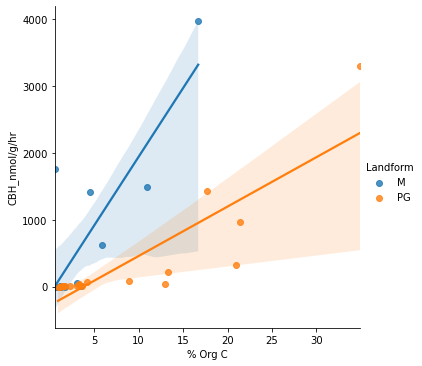

In [71]:
sns.lmplot('% Org C','CBH_nmol/g/hr', hue = 'Landform', data = map_df)

In [13]:
map_df.columns

Index(['LinkerPrimerSequence', 'BarcodeSequence', 'Landform', 'Pit',
       'Landform.1', 'ID', 'Depth(cm)', 'Depth_category', 'Depth_PG_M', 'x',
       'y', 'date', 'year', 'year_landform', 'precip_1month', 'precip_2month',
       'pH', 'Co2-C (ug/m^2) stone-free', 'PMC (ug/g soil)',
       'Total C (mg/g soil)', 'Total N (mg/g soil)', 'Missing16S',
       'MissingITS', 'BD (g/cm3)', '% total C', '% Minerals', '% OM',
       '% Org C', 'org c (g/kg)', '% C', '% N', 'C:N', 'Post DOC (mg/ g soil)',
       'Post DON (mg/ g soil)', 'C (g/m^2)', 'N (g/m^2)',
       'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)', '% Sand', '% Silt',
       '% Clay', 'BG_nmol/g/hr', 'CBH_nmol/g/hr', 'PHOS_nmol/g/hr',
       'NAG_nmol/g/hr', 'BX_nmol/g/hr', 'AG_nmol/g/hr', 'LAP_nmol/g/hr',
       'BG_umol/cm^2 stone-free', 'CBH_umol/cm^2 stone-free',
       'PHOS_umol/cm^2 stone-free', 'NAG_umol/cm^2 stone-free',
       'BX_umol/cm^2 stone-free', 'AG_umol/cm^2 stone-free',
       'LAP_umol/cm^2 stone-free', '

In [14]:
map_df['Enz C:P'] = map_df['BG_umol/cm^2 SF C']/(map_df['PHOS_umol/cm^2 SF C'])
map_df['Enz C:N'] = map_df['BG_umol/cm^2 SF C']/(map_df['NAG_umol/cm^2 SF C'])
map_df['Enz N:P'] = map_df['NAG_umol/cm^2 SF C']/(map_df['PHOS_umol/cm^2 SF C'])

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step


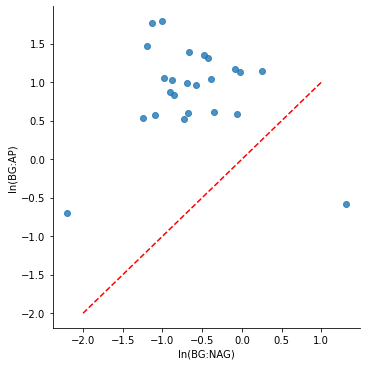

In [15]:
x = 'Enz C:P'
y = 'Enz C:N'
sns.lmplot(x, y, data = np.log(map_df[[x, y]]))
# sns.lmplot(x, y, data = map_df[[x, y, 'Landform']], hue = 'Landform')
plt.plot([-2, 1], [-2, 1], "r--")
plt.ylabel('ln(BG:AP)')
plt.xlabel('ln(BG:NAG)')
plt.savefig('../Figures/enzyme_ratios.jpg', format = 'jpg', dpi = 300, bbox_inches = 'tight')

In [16]:
map_df[[x, y]]

,Enz C:P,Enz C:N
M-SS2-11,NaN,NaN
M-SS2-130,NaN,NaN
M-SS2-160,NaN,NaN
M-SS2-30,inf,inf
M-SS2-80,NaN,NaN
M-SS3-120,0.109915,0.499876
M-SS3-150,NaN,NaN
M-SS3-20,0.336556,1.783938
M-SS3-200,NaN,NaN
M-SS3-46,0.436839,inf


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


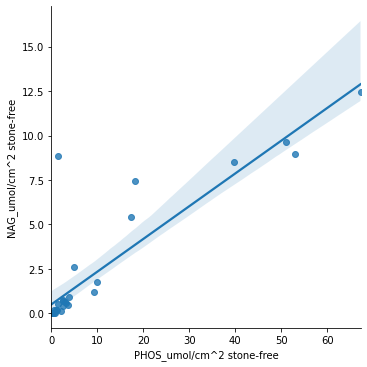

In [17]:
sns.lmplot('PHOS_umol/cm^2 stone-free', 'NAG_umol/cm^2 stone-free', data = map_df)

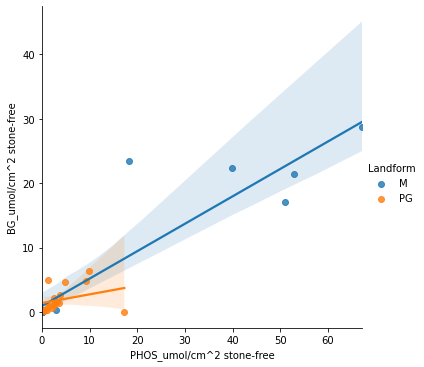

In [18]:
sns.lmplot(x = 'PHOS_umol/cm^2 stone-free', y = 'BG_umol/cm^2 stone-free', hue = 'Landform', data = map_df[['PHOS_umol/cm^2 stone-free', 'BG_umol/cm^2 stone-free', 'Landform']])

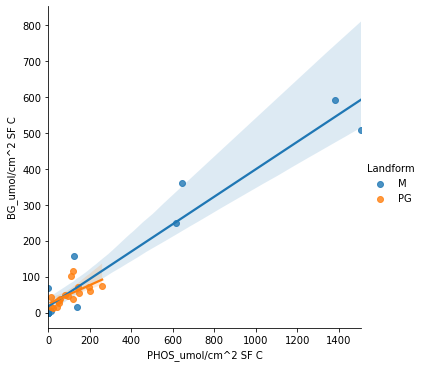

In [19]:
sns.lmplot(x = 'PHOS_umol/cm^2 SF C', y = 'BG_umol/cm^2 SF C', hue = 'Landform', data = map_df[['PHOS_umol/cm^2 SF C', 'BG_umol/cm^2 SF C', 'Landform']])

<AxesSubplot:xlabel='N (g/m^2)', ylabel='Total N (mg/g soil)'>

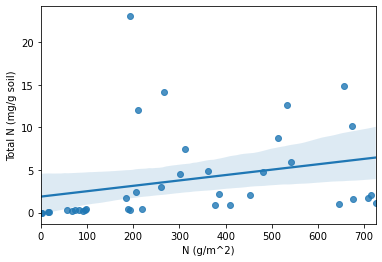

In [20]:
sns.regplot(x = 'N (g/m^2)', y = 'Total N (mg/g soil)', data = map_df)

In [21]:
# data['pH'] = np.log(data['pH'])
moore_lm = ols('C_kg_m_2 ~ Landform',data=map_df).fit()
sm.stats.anova_lm(moore_lm, typ=2)

,sum_sq,df,F,PR(>F)
Landform,67.986029,1.0,10.392551,0.002689
Residual,235.504928,36.0,NaN,NaN


In [22]:
map_df.columns.values

array(['LinkerPrimerSequence', 'BarcodeSequence', 'Landform', 'Pit',
       'Landform.1', 'ID', 'Depth(cm)', 'Depth_category', 'Depth_PG_M',
       'x', 'y', 'date', 'year', 'year_landform', 'precip_1month',
       'precip_2month', 'pH', 'Co2-C (ug/m^2) stone-free',
       'PMC (ug/g soil)', 'Total C (mg/g soil)', 'Total N (mg/g soil)',
       'Missing16S', 'MissingITS', 'BD (g/cm3)', '% total C',
       '% Minerals', '% OM', '% Org C', 'org c (g/kg)', '% C', '% N',
       'C:N', 'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)',
       'C (g/m^2)', 'N (g/m^2)', 'D21 NH4 + NO3 avg/sample',
       'NO3- (ug/g soil)', '% Sand', '% Silt', '% Clay', 'BG_nmol/g/hr',
       'CBH_nmol/g/hr', 'PHOS_nmol/g/hr', 'NAG_nmol/g/hr', 'BX_nmol/g/hr',
       'AG_nmol/g/hr', 'LAP_nmol/g/hr', 'BG_umol/cm^2 stone-free',
       'CBH_umol/cm^2 stone-free', 'PHOS_umol/cm^2 stone-free',
       'NAG_umol/cm^2 stone-free', 'BX_umol/cm^2 stone-free',
       'AG_umol/cm^2 stone-free', 'LAP_umol/cm^2 stone-free',
 

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


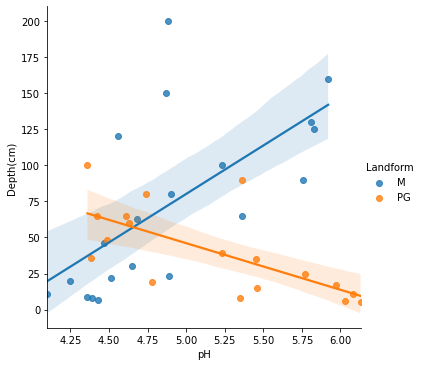

In [23]:
sns.lmplot('pH', 'Depth(cm)', hue = 'Landform', data = map_df)

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


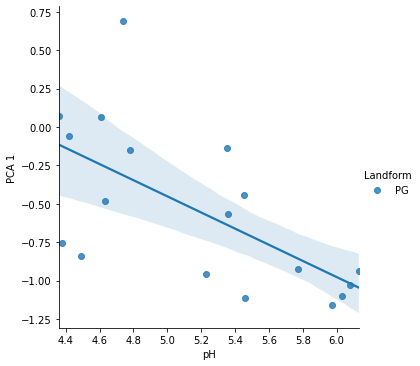

In [24]:
sns.lmplot('pH', 'PCA 1', hue = 'Landform', data = map_df[map_df['Landform'] == 'PG'])

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


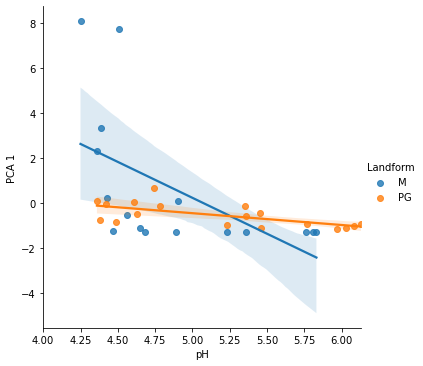

In [25]:
sns.lmplot('pH', 'PCA 1', hue = 'Landform', data = map_df)

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


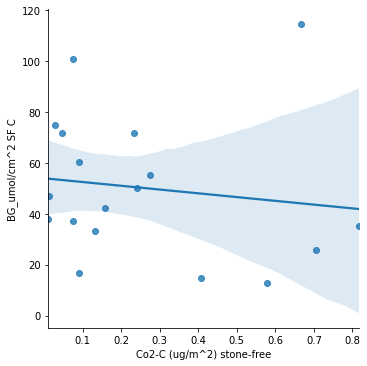

In [26]:
sns.lmplot('Co2-C (ug/m^2) stone-free', 'BG_umol/cm^2 SF C', data = map_df[map_df['Landform'] == 'PG'], order = 1)

<AxesSubplot:xlabel='Depth_PG_M', ylabel='pH'>

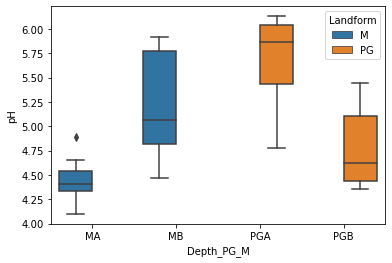

In [27]:
sns.boxplot(x = 'Depth_PG_M', y = 'pH', hue = 'Landform', data = map_df)

<AxesSubplot:xlabel='Depth_PG_M', ylabel='BG_umol/cm^2 SF C'>

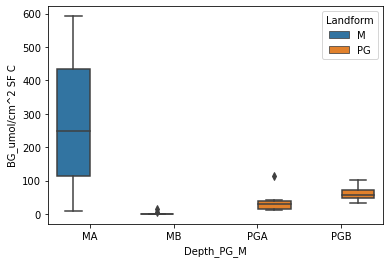

In [28]:
sns.boxplot(x = 'Depth_PG_M', y = 'BG_umol/cm^2 SF C', hue = 'Landform', data = map_df)

<AxesSubplot:xlabel='Depth_PG_M', ylabel='D21 NH4 + NO3 avg/sample'>

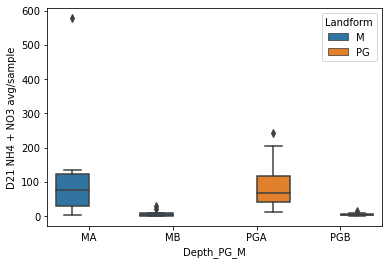

In [29]:
sns.boxplot(x = 'Depth_PG_M', y = 'D21 NH4 + NO3 avg/sample', hue = 'Landform', data = map_df)

In [30]:
map_df[['pH','PHOS_umol/cm^2 SF C','Depth_PG_M']]

,pH,PHOS_umol/cm^2 SF C,Depth_PG_M
M-SS2-11,4.10,NaN,MA
M-SS2-130,5.81,0.000000,MB
M-SS2-160,5.92,NaN,MB
M-SS2-30,4.65,0.000000,MA
M-SS2-80,4.90,0.000000,MB
M-SS3-120,4.56,139.796894,MB
M-SS3-150,4.87,NaN,MB
M-SS3-20,4.25,1509.750775,MA
M-SS3-200,4.88,NaN,MB
M-SS3-46,4.47,13.259953,MB


In [31]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    k = m-h
    if k < 0:
        k = 0
    return m, k, m+h

In [32]:
anova_df = pd.DataFrame()
mean_ci_df = pd.DataFrame()
columns_test = []
test = []
statistics = []
p_values = []
comparisons = {'M v PG':['M', 'PG'], 'MA v MB': ['MA','MB'], 'PGA v PGB':['PGA','PGB'], 
               'MA v PGA':['MA','PGA'], 'MB v PGB':['MB','PGB']}
means ={0:[],1: []}
lowers = {0:[],1: []}
uppers = {0:[],1: []}
columns = ['pH', 'Co2-C (ug/m^2) stone-free', 'PMC (ug/g soil)', 'Total C (mg/g soil)',
    'Total N (mg/g soil)','BD (g/cm3)', '% total C', '% Minerals', '% OM',
       '% Org C', 'org c (g/kg)', '% C', '% N', 'C:N',
       'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)', 'C (g/m^2)',
       'N (g/m^2)', 'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)',
       '% Sand', '% Silt', '% Clay', 'BG_umol/cm^2 SF C', 'CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C',
       'NAG_umol/cm^2 SF C', 'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C']
for comparison in comparisons:
    for column in map_df[columns]:
        if comparison == 'M v PG':
            category = 'Landform'
        else:
            category = 'Depth_PG_M'
        left = map_df[map_df.index.isin(map_df[map_df[category] == comparisons[comparison][0]].index)][column]
        right = map_df[map_df.index.isin(map_df[map_df[category] == comparisons[comparison][1]].index)][column]
        columns_test.append(column)
        test.append(comparison)
        statistic, p_value = stats.kruskal(left.dropna(),right.dropna())
        statistics.append(statistic)
        p_values.append(p_value)
        for i in range(2):
            mean_confidence = mean_confidence_interval(map_df[map_df[category] == comparisons[comparison][i]][column].dropna())
            means[i].append(mean_confidence[0])
            lowers[i].append(mean_confidence[1])
            uppers[i].append(mean_confidence[2])

anova_df['Columns'] = columns_test
anova_df['Comparison'] = test
anova_df['Statistic'] = statistics
anova_df['P_value'] = p_values
anova_df['Left_mean'] = means[0]
anova_df['Left_lower'] = lowers[0]
anova_df['Left_upper'] = uppers[0]
anova_df['Right_mean'] = means[1]
anova_df['Right_lower'] = lowers[1]
anova_df['Right_upper'] = uppers[1]
# anova_df.sort_values('Statistic', ascending=False, inplace=True)
anova_df.to_csv('../Statistics/map_df_kw_results.csv')
anova_df

,Columns,Comparison,Statistic,P_value,Left_mean,Left_lower,Left_upper,Right_mean,Right_lower,Right_upper
0,pH,M v PG,1.770025,0.183379,4.892500,4.625316,5.159684,5.180000,4.861594,5.498406
1,Co2-C (ug/m^2) stone-free,M v PG,0.480392,0.488245,0.799426,0.020185,1.578667,0.257836,0.127176,0.388496
2,PMC (ug/g soil),M v PG,0.308547,0.578573,461.367273,0.000000,980.315229,643.145059,45.966995,1240.323122
3,Total C (mg/g soil),M v PG,6.030769,0.014059,24.684000,7.202371,42.165629,73.948333,30.732351,117.164316
4,Total N (mg/g soil),M v PG,5.889323,0.015233,2.098000,0.642009,3.553991,5.851111,2.546903,9.155319
...,...,...,...,...,...,...,...,...,...,...
140,CBH_umol/cm^2 SF C,MB v PGB,3.091882,0.078684,26.304244,0.000000,74.925587,8.407431,4.234602,12.580260
141,PHOS_umol/cm^2 SF C,MB v PGB,11.217712,0.000810,17.006316,0.000000,52.560916,140.027117,94.482336,185.571898
142,NAG_umol/cm^2 SF C,MB v PGB,9.852652,0.001696,3.415461,0.000000,11.291528,21.268278,13.236021,29.300535
143,BX_umol/cm^2 SF C,MB v PGB,11.921569,0.000555,0.038794,0.000000,0.128255,102.071645,32.957915,171.185375


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Landform', ylabel='C_kg_m_2'>

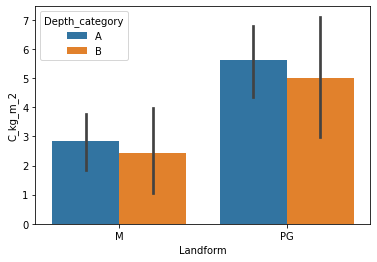

In [33]:
# sns.barplot('Landform','NAG_umol/cm^2 SF C', data = data)
sns.barplot('Landform','C_kg_m_2', hue = 'Depth_category', data = map_df)

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


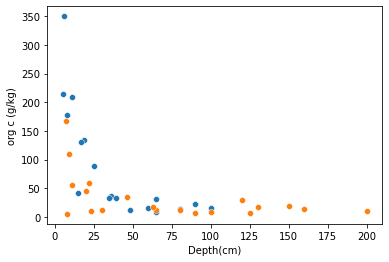

In [34]:
for i in ['PG','M']:
    x = map_df[map_df['Landform'] == i]['Depth(cm)']
    y = map_df[map_df['Landform'] == i]['org c (g/kg)']
    sns.scatterplot('Depth(cm)','org c (g/kg)', data = map_df[map_df['Landform'] == i])

In [35]:
# Get Lindas help with justification for removing sample
# removed ,'LAP_umol/cm^2 SF C'
features = ['BG_umol/cm^2 SF C',
       'CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C', 'NAG_umol/cm^2 SF C',
       'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C']
map_df_na = map_df[features].dropna()
# Separating out the features
x = map_df_na.loc[:, features].values
# Separating out the target
# y = map_df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, index = map_df_na.index
             , columns = ['PCA 1', 'PCA 2'])
map_df = pd.concat([map_df, principalDf], axis = 1)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
loadings

,PC1,PC2
BG_umol/cm^2 SF C,0.438018,-0.028715
CBH_umol/cm^2 SF C,0.328106,0.784655
PHOS_umol/cm^2 SF C,0.445421,-0.101305
NAG_umol/cm^2 SF C,0.441582,0.022067
BX_umol/cm^2 SF C,0.351586,-0.610409
AG_umol/cm^2 SF C,0.428345,0.011949


0.7777145575043782
0.6163776209306986
F_onewayResult(statistic=0.7265997000396643, pvalue=0.40013190777689067)


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<AxesSubplot:xlabel='Landform', ylabel='Co2-C (ug/m^2) stone-free'>

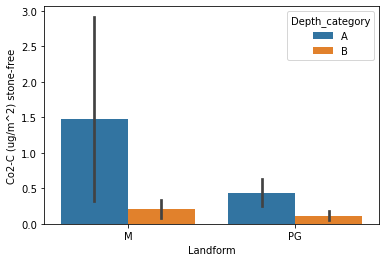

In [36]:
k2, p = stats.normaltest(np.log(map_df[map_df['Landform'] == 'M']['Co2-C (ug/m^2) stone-free'].dropna()))
print(p)
k2, p = stats.normaltest(np.log(map_df[map_df['Landform'] == 'PG']['Co2-C (ug/m^2) stone-free'].dropna()))
print(p)
print(f_oneway(np.log(map_df[map_df['Landform'] == 'PG']['Co2-C (ug/m^2) stone-free'].dropna()), 
               np.log(map_df[map_df['Landform'] == 'M']['Co2-C (ug/m^2) stone-free'].dropna())))
sns.barplot(x = 'Landform', y = 'Co2-C (ug/m^2) stone-free', hue = 'Depth_category', data = map_df)

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='C_kg_m_2', ylabel='N_kg_m_2'>

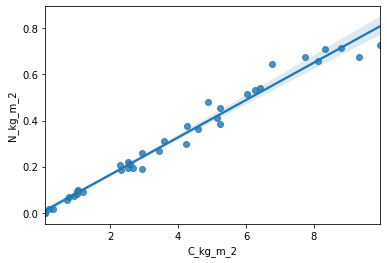

In [37]:
sns.regplot('C_kg_m_2', 'N_kg_m_2', data = map_df)

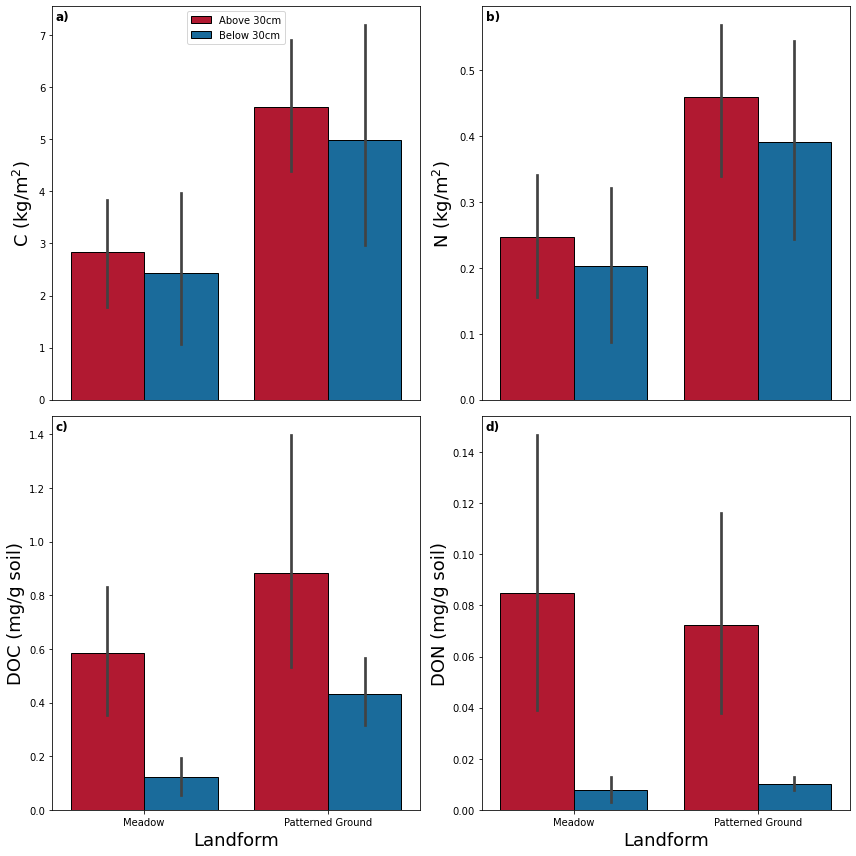

In [38]:
# total carbon, total nitrogen, BG, NAG for landform and depth
figsize = (12,12)
fig, axs = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=False)

kwargs = {'edgecolor': 'black'}

sns.barplot(x = 'Landform', y = 'C_kg_m_2', hue = 'Depth_category', data = map_df, palette = ['#ca0020', '#0571b0'],
            ax = axs[0,0], **kwargs)
axs[0,0].annotate('a)', size = 12, fontweight = 'bold',
                  xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
axs[0,0].set_ylabel('C (kg/m$^2$)', size=18)
axs[0,0].set_xticklabels(['Meadow', 'Patterned Ground'])
axs[0,0].legend(loc = 'upper center')
L=axs[0,0].legend(loc = 'upper center')
L.get_texts()[0].set_text('Above 30cm')
L.get_texts()[1].set_text('Below 30cm')
x_axis = axs[0,0].axes.get_xaxis()
x_axis.set_visible(False)

sns.barplot(x = 'Landform', y = 'N_kg_m_2', hue = 'Depth_category', data = map_df, palette = ['#ca0020', '#0571b0'], 
            ax = axs[0,1], **kwargs)
axs[0,1].annotate('b)', size = 12, fontweight = 'bold',
                  xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
axs[0,1].set_ylabel('N (kg/m$^2$)', size=18)
axs[0,1].set_xticklabels(['Meadow', 'Patterned Ground'])
axs[0,1].get_legend().remove()
x_axis = axs[0,1].axes.get_xaxis()
x_axis.set_visible(False)

sns.barplot(x = 'Landform', y = 'Post DOC (mg/ g soil)', hue = 'Depth_category', data = map_df, palette = ['#ca0020', '#0571b0'],
            ax = axs[1,0], **kwargs)
axs[1,0].annotate('c)', size = 12, fontweight = 'bold',
                  xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
axs[1,0].set_xticklabels(['Meadow', 'Patterned Ground'])
axs[1,0].set_ylabel('DOC (mg/g soil)', size=18)
axs[1,0].set_xlabel('Landform', size=18)
axs[1,0].get_legend().remove()

sns.barplot(x = 'Landform', y = 'Post DON (mg/ g soil)', hue = 'Depth_category', data = map_df, palette = ['#ca0020', '#0571b0'],
            ax = axs[1,1], **kwargs)
axs[1,1].annotate('d)', size = 12, fontweight = 'bold',
                  xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
axs[1,1].set_xticklabels(['Meadow', 'Patterned Ground'])
axs[1,1].set_ylabel('DON (mg/g soil)', size=18)
axs[1,1].set_xlabel('Landform', size=18)
axs[1,1].get_legend().remove()

plt.tight_layout()

filename = 'depth_landform_C_N_c_n.jpg'
plt.savefig('../Figures/' + filename, dpi = 300, format = 'jpg')

In [39]:
Counter(map_df['Depth_PG_M'])

Counter({'MA': 8, 'MB': 12, 'PGA': 8, 'PGB': 10})

In [40]:
map_df[map_df['Depth_PG_M'] == 'PGA']['PCA 1'].dropna()

,PCA 1,PCA 1
PG-PG1-19,-0.146448,-0.146448
PG-PG1-6,-1.102721,-1.102721
PG-PG2-11,-1.029505,-1.029505
PG-PG2-25,-0.925345,-0.925345
PG-PG3-15,-1.113720,-1.113720
PG-PG3-8,-0.139007,-0.139007
PG-SS1-17,-1.157252,-1.157252
PG-SS1-5,-0.939046,-0.939046


In [41]:
k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'PGA']['PCA 1'].dropna())
print(p)
k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'PGB']['PCA 1'].dropna())
print(p)
k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'PGA']['PCA 2'].dropna())
print(p)
k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'PGB']['PCA 2'].dropna())
print(p)
# k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'MA']['PCA 1'].dropna())
# print(p)
k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'MB']['PCA 1'].dropna())
print(p)
# k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'MA']['PCA 2'].dropna())
# print(p)
k2, p = stats.normaltest(map_df[map_df['Depth_PG_M'] == 'MB']['PCA 2'].dropna())
print(p)

[0.2312294 0.2312294]
[0.52704202 0.52704202]
[0.25017883 0.25017883]
[0.34215975 0.34215975]
[0.00425734 0.00425734]
[1.6304284e-05 1.6304284e-05]


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))
/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/home/bostevens/anaconda3/envs/py36/li

In [42]:
print(f_oneway(map_df[map_df['Depth_PG_M'] == 'PGA']['PCA 1'], map_df[map_df['Depth_PG_M'] == 'PGB']['PCA 1']))
print(f_oneway(map_df[map_df['Depth_PG_M'] == 'PGA']['PCA 2'], map_df[map_df['Depth_PG_M'] == 'PGB']['PCA 2']))
print(stats.kruskal(map_df[map_df['Depth_PG_M'] == 'MA']['PCA 1'].dropna(), map_df[map_df['Depth_PG_M'] == 'MB']['PCA 1'].dropna()))
print(stats.kruskal(map_df[map_df['Depth_PG_M'] == 'MA']['PCA 2'].dropna(), map_df[map_df['Depth_PG_M'] == 'MB']['PCA 2'].dropna()))

F_onewayResult(statistic=array([4.72901264, 4.72901264]), pvalue=array([0.04500307, 0.04500307]))
F_onewayResult(statistic=array([10.30180593, 10.30180593]), pvalue=array([0.0054658, 0.0054658]))
KruskalResult(statistic=277.7756302521009, pvalue=2.2926176590903356e-62)
KruskalResult(statistic=106.60121381886091, pvalue=5.443984852967382e-25)


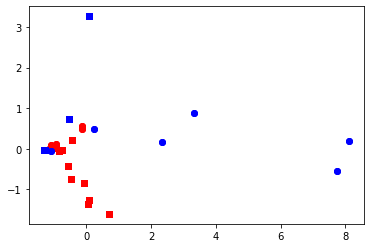

In [43]:
plt.scatter(x = 'PCA 1', y = 'PCA 2', data = map_df[map_df['Depth_PG_M'] == 'PGA'], marker = 'o', color = 'red')
plt.scatter(x = 'PCA 1', y = 'PCA 2', data = map_df[map_df['Depth_PG_M'] == 'PGB'], marker = 's', color = 'red')
plt.scatter(x = 'PCA 1', y = 'PCA 2', data = map_df[map_df['Depth_PG_M'] == 'MA'], marker = 'o', color = 'blue')
plt.scatter(x = 'PCA 1', y = 'PCA 2', data = map_df[map_df['Depth_PG_M'] == 'MB'], marker = 's', color = 'blue')

F_onewayResult(statistic=3.597534335969226, pvalue=0.06591146899357639)


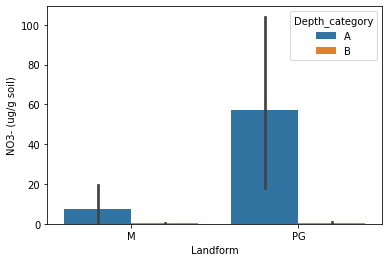

In [44]:
# Does not match Fig. 4 from Zoe's paper
# df = data[data['Depth(cm)'] <= 30].copy()
# 'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)', 'C (g/m^2)',
#        'N (g/m^2)', 'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)',
#        '% Sand', '% Silt', '% Clay'
df = map_df
# column = 'BG_nmol/g/hr'
# column = '% Org C'
column = 'NO3- (ug/g soil)'
# column = 'C (kg/m^2)'
# column = 'N (kg/m^2)'

sns.barplot(x = 'Landform', y = column, hue = 'Depth_category', data = df)
print(f_oneway(df[df['Landform'] == 'PG'][column], df[df['Landform'] == 'M'][column]))

In [45]:
# Figure of standardized average enzyme activity
# x = df[['BG_umol/cm^2 SF C','CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C', 'NAG_umol/cm^2 SF C',
#         'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C', 'LAP_umol/cm^2 SF C']].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

In [46]:
# Figure of all enzymes in one image, separated by depth category

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Landform', ylabel='N (g/m^2)'>

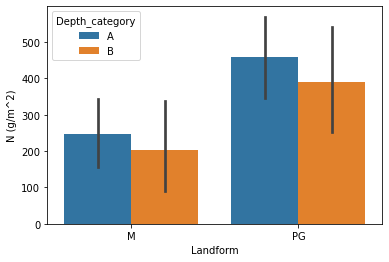

In [47]:
sns.barplot('Landform','N (g/m^2)', hue = 'Depth_category', data = df)

F_onewayResult(statistic=2.829471191836415, pvalue=0.10736071108284975)


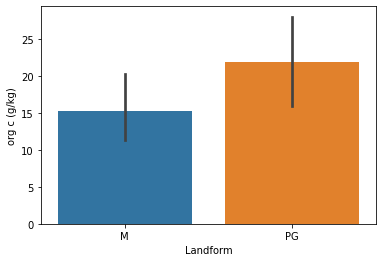

In [48]:
below_30 = map_df[map_df['Depth(cm)'] >= 30]
sns.barplot(x = 'Landform', y = 'org c (g/kg)', data = below_30)
print(f_oneway(below_30[below_30['Landform'] == 'PG']['org c (g/kg)'], below_30[below_30['Landform'] == 'M']['org c (g/kg)']))

F_onewayResult(statistic=10.056819727477137, pvalue=0.006798310478565055)


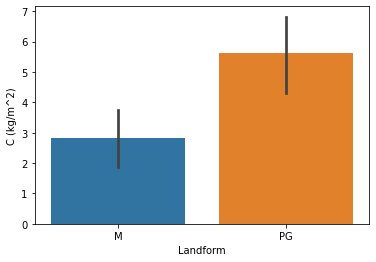

In [49]:
top_30 = map_df[map_df['Depth(cm)'] <= 30].copy()
sns.barplot(x = 'Landform', y = 'C (kg/m^2)', data = top_30)
print(f_oneway(top_30[top_30['Landform'] == 'PG']['C (kg/m^2)'], top_30[top_30['Landform'] == 'M']['C (kg/m^2)']))

F_onewayResult(statistic=17.616888379726245, pvalue=0.0008953210000032353)


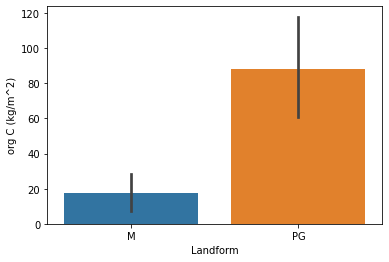

In [50]:
top_30 = map_df[map_df['Depth(cm)'] <= 30].copy()
sns.barplot(x = 'Landform', y = 'org C (kg/m^2)', data = top_30)
print(f_oneway(top_30[top_30['Landform'] == 'PG']['org C (kg/m^2)'], top_30[top_30['Landform'] == 'M']['org C (kg/m^2)']))
# PG is about 2-3 times higher than other studies in the rockies

F_onewayResult(statistic=2.2313988500461703, pvalue=0.14473233526703141)


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


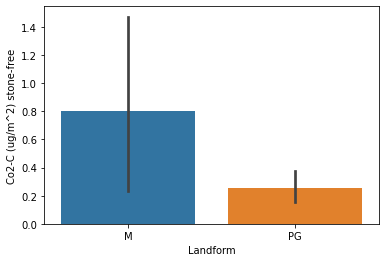

In [51]:
df = map_df
column = 'Co2-C (ug/m^2) stone-free'
sns.barplot('Landform', column, data=map_df)
print(f_oneway(df[df['Landform'] == 'PG'][column].dropna(), df[df['Landform'] == 'M'][column].dropna()))

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


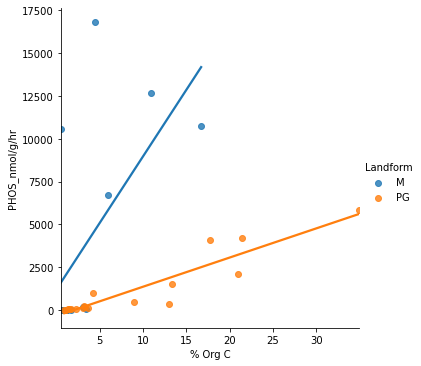

In [52]:
sns.lmplot('% Org C','PHOS_nmol/g/hr', hue = 'Landform', data = map_df, ci = False)

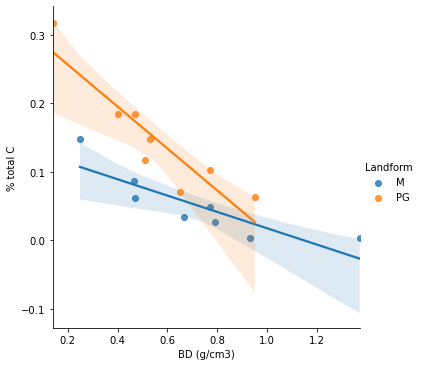

In [53]:
sns.lmplot(x = 'BD (g/cm3)', y ='% total C', hue = 'Landform', data = top_30)

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Landform', ylabel='Co2-C (ug/m^2) stone-free'>

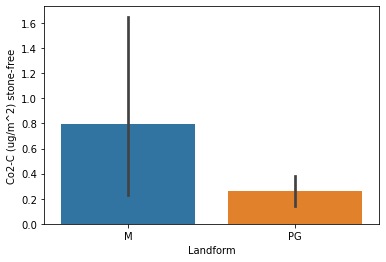

In [54]:
sns.barplot('Landform', 'Co2-C (ug/m^2) stone-free', data = map_df)

In [55]:
alpha_div_16S = pd.DataFrame()
alpha_div_ITS = pd.DataFrame()
shannon_16S_df_paired = pd.read_csv('../Bioinformatics/16S/core-metrics-results-paired/shannon/alpha-diversity.tsv', sep = '\t', index_col = 0)
otu_16S_df_paired = pd.read_csv('../Bioinformatics/16S/core-metrics-results-paired/otus/alpha-diversity.tsv', sep = '\t', index_col = 0)
evenness_16S_df_paired = pd.read_csv('../Bioinformatics/16S/core-metrics-results-paired/evenness/alpha-diversity.tsv', sep = '\t', index_col = 0)
faith_16S_df_paired = pd.read_csv('../Bioinformatics/16S/core-metrics-results-paired/faith-pd/alpha-diversity.tsv', sep = '\t', index_col = 0)
shannon_ITS_df_paired = pd.read_csv('../Bioinformatics/ITS/core-metrics-results-paired/shannon/alpha-diversity.tsv', sep = '\t', index_col = 0)
otu_ITS_df_paired = pd.read_csv('../Bioinformatics/ITS/core-metrics-results-paired/otus/alpha-diversity.tsv', sep = '\t', index_col = 0)
evenness_ITS_df_paired = pd.read_csv('../Bioinformatics/ITS/core-metrics-results-paired/evenness/alpha-diversity.tsv', sep = '\t', index_col = 0)
faith_ITS_df_paired = pd.read_csv('../Bioinformatics/ITS/core-metrics-results-paired/faith-pd/alpha-diversity.tsv', sep = '\t', index_col = 0)

alpha_div_16S['Shannon_16S'] = shannon_16S_df_paired['shannon_entropy']
alpha_div_16S['OTUs_16S'] = otu_16S_df_paired['observed_features']
alpha_div_16S['Evenness_16S'] = evenness_16S_df_paired['pielou_evenness']
alpha_div_16S['Faith_16S'] = faith_16S_df_paired['faith_pd']
alpha_div_ITS['Shannon_ITS'] = shannon_ITS_df_paired['shannon_entropy']
alpha_div_ITS['OTUs_ITS'] = otu_ITS_df_paired['observed_features']
alpha_div_ITS['Evenness_ITS'] = evenness_ITS_df_paired['pielou_evenness']
alpha_div_ITS['Faith_ITS'] = faith_ITS_df_paired['faith_pd']

columns = ['Depth(cm)', 'pH','Co2-C (ug/m^2) stone-free', 'PMC (ug/g soil)', 
           'Total C (mg/g soil)', 'Total N (mg/g soil)',
           'BD (g/cm3)', '% total C', '% Minerals', '% OM', '% Org C',
           'org c (g/kg)', '% C', '% N', 'C:N', 'Post DOC (mg/ g soil)',
           'Post DON (mg/ g soil)', 'C (g/m^2)', 'N (g/m^2)',
           'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)', '% Sand', '% Silt',
           '% Clay','PCA 1','PCA 2','C (kg/m^2)', 'org C (kg/m^2)',
           'BG_umol/cm^2 SF C', 'CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C',
       'NAG_umol/cm^2 SF C', 'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C']
columns.append('Landform')
alpha_div_16S = alpha_div_16S.merge(map_df[columns], left_index=True, right_index=True)
alpha_div_ITS = alpha_div_ITS.merge(map_df[columns], left_index=True, right_index=True)
# alpha_div['Landform'] = data['Landform']
# alpha_div['Depth(cm)'] = data['Depth(cm)']
alpha_div_16S.head()

,Shannon_16S,OTUs_16S,Evenness_16S,Faith_16S,Depth(cm),pH,Co2-C (ug/m^2) stone-free,PMC (ug/g soil),Total C (mg/g soil),Total N (mg/g soil),...,PCA 2,C (kg/m^2),org C (kg/m^2),BG_umol/cm^2 SF C,CBH_umol/cm^2 SF C,PHOS_umol/cm^2 SF C,NAG_umol/cm^2 SF C,BX_umol/cm^2 SF C,AG_umol/cm^2 SF C,Landform
M-SS2-11,7.356170,214,0.950229,19.753039,11,4.10,0.624896,757.271683,26.41,2.38,...,NaN,2.294039,12.754855,NaN,NaN,NaN,NaN,NaN,NaN,M
M-SS2-30,7.566694,289,0.925598,24.900712,30,4.65,0.129643,55.346917,3.94,0.32,...,-0.052638,1.025437,1.261287,67.614702,0.000000,0.000000,0.000000,0.00000,0.0,M
M-SS2-80,7.834565,363,0.921299,27.768865,80,4.90,0.203994,31.420367,1.85,0.14,...,3.268604,1.201094,1.405281,0.000000,189.976736,0.000000,0.000000,0.00000,0.0,M
M-SS3-120,6.615748,140,0.927968,14.234310,120,4.56,0.566158,152.581913,20.65,1.76,...,0.731795,8.320059,25.209777,15.365772,46.307890,139.796894,30.739149,0.34915,0.0,M
M-SS3-150,6.182769,143,0.863531,14.921211,150,4.87,NaN,71.793379,11.67,0.93,...,NaN,5.147910,9.626592,NaN,NaN,NaN,NaN,NaN,NaN,M


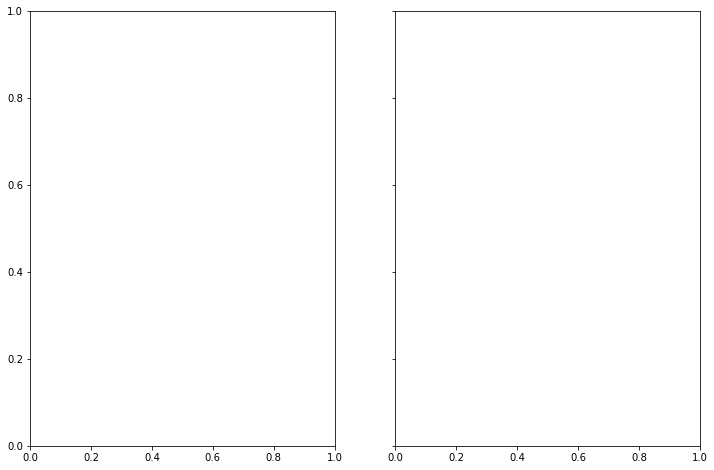

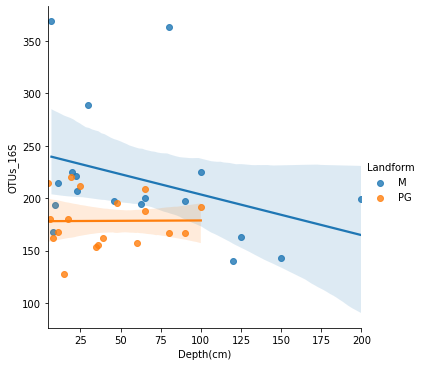

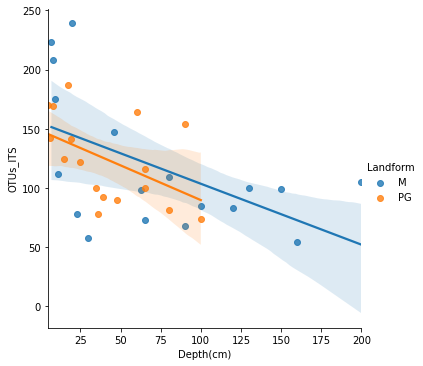

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12,8), sharey=True, sharex=False)

axes[0] = sns.lmplot(x = 'Depth(cm)', y = 'OTUs_16S', hue = 'Landform', data = alpha_div_16S)
axes[1] = sns.lmplot(x = 'Depth(cm)', y = 'OTUs_ITS', hue = 'Landform', data = alpha_div_ITS)

In [88]:
ys = ['Depth(cm)', 'pH', 'Co2-C (ug/m^2) stone-free',
       'PMC (ug/g soil)', 'Total C (mg/g soil)', 'Total N (mg/g soil)',
       'BD (g/cm3)', '% total C',
       '% Minerals', '% OM', '% Org C', 'org c (g/kg)', '% C', '% N',
       'C:N', 'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)',
       'C (g/m^2)', 'N (g/m^2)', 'D21 NH4 + NO3 avg/sample',
       'NO3- (ug/g soil)', '% Sand', '% Silt', '% Clay']
xs = ['Shannon', 'OTUs', 'Evenness', 'Faith']

corr_list = []
lasso_list = []
for df in ['16S', 'ITS']:
    for landform in ['PG','M']:
        for x in xs:
            xi = x + '_' + df
            for y in ys:
                if df == '16S':
                    df_corr = alpha_div_16S
                elif df == 'ITS':
                    df_corr = alpha_div_ITS
                df_corr = df_corr[df_corr['Landform'] == landform]
                df_corr_r = df_corr[[xi, y]].dropna()
                slope, intercept, r_value, p_value, std_err = stats.linregress(df_corr_r[xi],df_corr_r[y])
                corr_list.append([df, xi, y, landform, r_value])
        ## Lasso
#             lasso_df = df_corr[columns_target].dropna()
            df_corr = df_corr.dropna()
            target = df_corr[xi]
            features = df_corr[ys]
            lass_cv = LassoCV(alphas=[-100, -10, 0.1, 0.001, 0.0001, 1, 10, 100, 1000], tol = 1, max_iter = 100000)
            model_cv = lass_cv.fit(features, target)
            lasso_list.extend(model_cv.coef_)
        
output_df = pd.DataFrame(corr_list, columns = ['DF', 'X', 'Y', 'Landform', 'r'])
output_df['Lasso'] = lasso_list
output_df.to_csv('../Statistics/landform_richness_correlations.csv')

In [84]:
lasso_list

[array([ 0., -0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0., -0., -0.,
        -0., -0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0.]),
 array([ 0.        , -0.        , -0.        , -0.00559731,  0.        ,
         0.        ,  0.        ,  0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.0015229 ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        ,  0.        ]),
 array([ 0., -0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0., -0., -0.,
        -0.,  0.,  0., -0., -0., -0., -0., -0.,  0., -0., -0.]),
 array([ 0.        , -0.        , -0.        , -0.00025741,  0.        ,
         0.        , -0.        ,  0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.00027975,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        ,  0.        ]),
 array([-0., -0.

In [88]:
alpha_div_ITS.mean()

Shannon_ITS       4.771762
OTUs_ITS        120.514286
Evenness_ITS      0.701876
Faith_ITS        24.011555
Depth(cm)        57.857143
dtype: float64

In [89]:
alpha_div_ITS.std()

Shannon_ITS      0.934688
OTUs_ITS        47.524836
Evenness_ITS     0.136315
Faith_ITS        8.020335
Depth(cm)       49.620408
dtype: float64

In [91]:
alpha_div_16S_pg = alpha_div_16S[alpha_div_16S['Landform'] == 'PG']
alpha_div_16S_m = alpha_div_16S[alpha_div_16S['Landform'] == 'M']
for metric in ['Shannon_16S','OTUs_16S','Evenness_16S','Faith_16S']:
    print(f_oneway(alpha_div_16S_pg[metric], alpha_div_16S_m[metric]))

F_onewayResult(statistic=3.277218973712939, pvalue=0.07909364714712591)
F_onewayResult(statistic=5.765077659184974, pvalue=0.02196365226574083)
F_onewayResult(statistic=0.5777648024115445, pvalue=0.4524286720094075)
F_onewayResult(statistic=3.3451975683772375, pvalue=0.07618409466878238)


In [13]:
moore_lm = ols('OTUs_16S ~ Landform',data=alpha_div_16S).fit()
sm.stats.anova_lm(moore_lm, typ=2)

NameError: name 'alpha_div_16S' is not defined

In [92]:
alpha_div_ITS_pg = alpha_div_ITS[alpha_div_ITS['Landform'] == 'PG']
alpha_div_ITS_m = alpha_div_ITS[alpha_div_ITS['Landform'] == 'M']
for metric in ['Shannon_ITS','OTUs_ITS','Evenness_ITS','Faith_ITS']:
    print(f_oneway(alpha_div_ITS_pg[metric], alpha_div_ITS_m[metric]))

F_onewayResult(statistic=0.03889383960757482, pvalue=0.8448688255817636)
F_onewayResult(statistic=0.150763713721705, pvalue=0.7003002925414714)
F_onewayResult(statistic=0.3569466135074641, pvalue=0.5542847634708986)
F_onewayResult(statistic=1.4895705912490322, pvalue=0.23093279742893416)


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='variable', ylabel='value'>

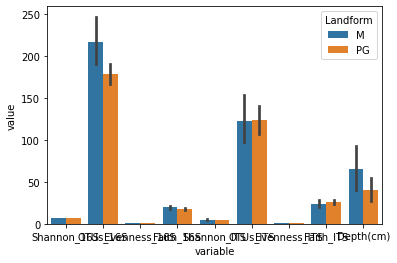

In [68]:
sns.barplot('variable', 'value', hue ='Landform', data = alpha_div.melt(id_vars=['Landform']))

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='variable', ylabel='value'>

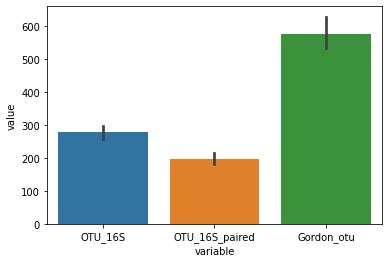

In [19]:
sns.barplot('variable','value',data = alpha_div[['OTU_16S','OTU_16S_paired','Gordon_otu']].melt())

In [36]:
dada_stats_16s = pd.read_csv('../Bioinformatics/16S/metadata-paired.tsv', index_col= 0,sep = '\t')
dada_stats_16s.head()

,input,filtered,percentage of input passed filter,denoised,merged,percentage of input merged,non-chimeric,percentage of input non-chimeric
sample-id,,,,,,,,
M-SS2-11,34138,24512,71.80,22236,16622,48.69,11471,33.60
M-SS2-30,70293,48939,69.62,45997,40058,56.99,22350,31.80
M-SS2-80,97895,69248,70.74,66183,57710,58.95,27762,28.36
M-SS3-120,31400,22614,72.02,21253,18406,58.62,9568,30.47
M-SS3-150,33903,23431,69.11,21971,19378,57.16,11139,32.86


In [21]:
alpha_div = alpha_div.merge(dada_stats, left_index=True, right_index=True)

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


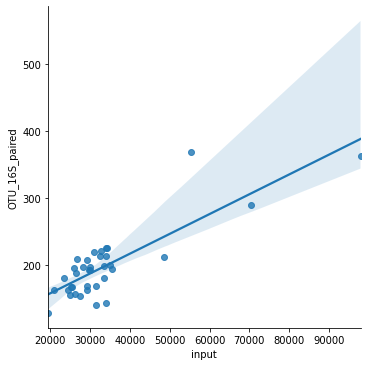

In [40]:
sns.lmplot('input', 'OTU_16S_paired', data=alpha_div)

In [26]:
print(dada_stats_16s.sum(0))

input                                1206993.00
filtered                              881115.00
percentage of input passed filter       2638.21
denoised                              803127.00
merged                                618272.00
percentage of input merged              1817.10
non-chimeric                          402471.00
percentage of input non-chimeric        1212.28
dtype: float64

In [27]:
dada_stats_16s.mean()

input                                33527.583333
filtered                             24475.416667
percentage of input passed filter       73.283611
denoised                             22309.083333
merged                               17174.222222
percentage of input merged              50.475000
non-chimeric                         11179.750000
percentage of input non-chimeric        33.674444
dtype: float64

In [33]:
dada_stats_ITS = pd.read_csv('../Bioinformatics/ITS/metadata-paired.tsv', index_col= 0,sep = '\t')
# print(dada_stats_ITS.head())
print(dada_stats_ITS.sum(0))
print(dada_stats_ITS.mean())

input                                979103.00
filtered                             841028.00
percentage of input passed filter      3015.93
denoised                             838166.00
merged                               692771.00
percentage of input merged             2481.47
non-chimeric                         684916.00
percentage of input non-chimeric       2453.66
dtype: float64
input                                27974.371429
filtered                             24029.371429
percentage of input passed filter       86.169429
denoised                             23947.600000
merged                               19793.457143
percentage of input merged              70.899143
non-chimeric                         19569.028571
percentage of input non-chimeric        70.104571
dtype: float64


In [25]:
# Lasso

In [28]:
map_df.columns.values

array(['LinkerPrimerSequence', 'BarcodeSequence', 'Landform', 'Pit',
       'Landform.1', 'ID', 'Depth(cm)', 'Depth_category', 'Depth_PG_M',
       'x', 'y', 'date', 'year', 'year_landform', 'precip_1month',
       'precip_2month', 'pH', 'Co2-C (ug/m^2) stone-free',
       'PMC (ug/g soil)', 'Total C (mg/g soil)', 'Total N (mg/g soil)',
       'Missing16S', 'MissingITS', 'BD (g/cm3)', '% total C',
       '% Minerals', '% OM', '% Org C', 'org c (g/kg)', '% C', '% N',
       'C:N', 'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)',
       'C (g/m^2)', 'N (g/m^2)', 'D21 NH4 + NO3 avg/sample',
       'NO3- (ug/g soil)', '% Sand', '% Silt', '% Clay', 'BG_nmol/g/hr',
       'CBH_nmol/g/hr', 'PHOS_nmol/g/hr', 'NAG_nmol/g/hr', 'BX_nmol/g/hr',
       'AG_nmol/g/hr', 'LAP_nmol/g/hr', 'BG_umol/cm^2 stone-free',
       'CBH_umol/cm^2 stone-free', 'PHOS_umol/cm^2 stone-free',
       'NAG_umol/cm^2 stone-free', 'BX_umol/cm^2 stone-free',
       'AG_umol/cm^2 stone-free', 'LAP_umol/cm^2 stone-free',
 

0.001


<AxesSubplot:>

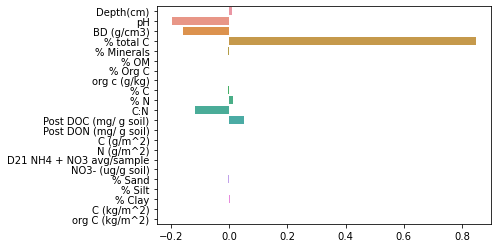

In [10]:
variable = 'PCA 1'
landform = 'PG'
columns = ['Depth(cm)', 'pH',
           'BD (g/cm3)', '% total C', '% Minerals', '% OM', '% Org C',
           'org c (g/kg)', '% C', '% N', 'C:N', 'Post DOC (mg/ g soil)',
           'Post DON (mg/ g soil)', 'C (g/m^2)', 'N (g/m^2)',
           'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)', '% Sand', '% Silt',
           '% Clay','C (kg/m^2)', 'org C (kg/m^2)']

columns_target = columns.copy()
columns_target.append(variable)
lasso_df = map_df[map_df['Landform'] == landform]
lasso_df = lasso_df[columns_target].dropna()
target = lasso_df[variable]
features = lasso_df[columns]

lass_cv = LassoCV(alphas=[-100, -10, 0.1, 0.001, 0.0001, 1, 10, 100, 1000], tol = 10, max_iter = 100000)
model_cv = lass_cv.fit(features, target)
print(model_cv.alpha_)
sns.barplot(x=model_cv.coef_, y = features.columns)

In [80]:
model_cv.coef_

array([ 1.15826755e-02, -1.96182338e-01, -1.56923293e-01,  8.48301662e-01,
       -2.61147890e-03,  0.00000000e+00,  0.00000000e+00,  8.83177592e-07,
       -1.74282785e-03,  1.39164109e-02, -1.16902451e-01,  5.05072850e-02,
       -0.00000000e+00, -4.17340400e-05, -2.62249373e-05, -4.61187735e-04,
       -7.76548884e-04, -1.70555181e-03, -5.68290504e-04,  3.21966355e-03,
       -1.26935226e-04,  2.11292270e-04])